# Structure embedding evaluation (100 repositories / validation set)

## 1. Loading repository information

In [2]:
!pip install gdown
!gdown 12njH7JojRSgK6yzfHmhdZSrnfVN9x9NQ

Downloading...
From: https://drive.google.com/uc?id=12njH7JojRSgK6yzfHmhdZSrnfVN9x9NQ
To: /content/repo_info_validation.pkl
100% 51.4M/51.4M [00:00<00:00, 185MB/s]


In [3]:
import pickle

with open("repo_info_validation.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [4]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=1ffbfc650b8836d639e519a93736e7487c0d382c590f05c044d28f7497f1989c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [5]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [6]:
sentence_transformer_model_names = [
    "sentence-transformers/bert-base-nli-mean-tokens",
]

In [7]:
from sentence_transformers import SentenceTransformer

sentence_transformer_models = {}

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

## 3. Generating structure embeddings

In [8]:
# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}

    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = embeddings_list

    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "structure":
            return get_other_embeddings(input_data)


In [9]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating structure embeddings for {repo_name} - ")
    repo_dict["structure_embeddings"] = get_embeddings(input_data=repo_dict["structure"], input_mode="structure")

  0%|          | 0/100 [00:00<?, ?it/s]

 - Generating structure embeddings for pyparsing/pyparsing - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



  1%|          | 1/100 [00:07<11:50,  7.18s/it]

 - Generating structure embeddings for JohnLangford/vowpal_wabbit - 



100%|██████████| 1/1 [00:00<00:00, 62.26it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for django/channels - 



100%|██████████| 1/1 [00:00<00:00, 63.15it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for gak/pycallgraph - 



100%|██████████| 1/1 [00:00<00:00, 57.69it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for Microsoft/PTVS - 



100%|██████████| 1/1 [00:00<00:00, 65.94it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for fabtools/fabtools - 



  6%|▌         | 6/100 [00:07<01:24,  1.11it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for indico/indico - 



100%|██████████| 1/1 [00:00<00:00, 62.89it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for ray-project/ray - 



100%|██████████| 1/1 [00:00<00:00, 62.57it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PyMySQL/PyMySQL - 



100%|██████████| 1/1 [00:00<00:00, 64.47it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for fxsjy/jieba - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.95it/s]


 - Generating structure embeddings for tartiflette/tartiflette-asgi - 



 11%|█         | 11/100 [00:07<00:36,  2.42it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for nose-devs/nose2 - 



100%|██████████| 1/1 [00:00<00:00, 58.75it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for lepture/mistune - 



100%|██████████| 1/1 [00:00<00:00, 65.86it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for worldveil/dejavu - 



100%|██████████| 1/1 [00:00<00:00, 63.82it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for willmcgugan/rich - 



100%|██████████| 1/1 [00:00<00:00, 66.32it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for PetrochukM/PyTorch-NLP - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 16%|█▌        | 16/100 [00:07<00:20,  4.17it/s]

 - Generating structure embeddings for ionelmc/python-hunter - 



100%|██████████| 1/1 [00:00<00:00, 54.12it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for WhyNotHugo/python-barcode - 



100%|██████████| 1/1 [00:00<00:00, 61.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 - Generating structure embeddings for davedoesdev/python-jwt - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 59.46it/s]


 - Generating structure embeddings for chriskiehl/Gooey - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 53.57it/s]


 - Generating structure embeddings for jpadilla/pyjwt - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 21%|██        | 21/100 [00:07<00:12,  6.39it/s]

 - Generating structure embeddings for mindsdb/mindsdb - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 56.09it/s]


 - Generating structure embeddings for facebookresearch/hydra - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 47.03it/s]


 - Generating structure embeddings for Instagram/MonkeyType - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 53.98it/s]


 - Generating structure embeddings for frewsxcv/python-geojson - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 25%|██▌       | 25/100 [00:07<00:08,  8.61it/s]

 - Generating structure embeddings for zostera/django-bootstrap4 - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 59.45it/s]


 - Generating structure embeddings for google/pytype - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


 - Generating structure embeddings for pricingassistant/mrq - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 57.95it/s]


 - Generating structure embeddings for tylerlaberge/PyPattyrn - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 52.41it/s]


 - Generating structure embeddings for mkdocs/mkdocs - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 30%|███       | 30/100 [00:07<00:05, 11.98it/s]

 - Generating structure embeddings for ionelmc/python-manhole - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


 - Generating structure embeddings for encode/uvicorn - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 52.90it/s]


 - Generating structure embeddings for davidhalter/jedi - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 51.36it/s]


 - Generating structure embeddings for tomerfiliba/rpyc - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 61.04it/s]


 - Generating structure embeddings for python-greenlet/greenlet - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 35%|███▌      | 35/100 [00:07<00:04, 15.71it/s]

 - Generating structure embeddings for scottrogowski/code2flow - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 61.51it/s]


 - Generating structure embeddings for jiaaro/pydub - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 42.66it/s]


 - Generating structure embeddings for python-rope/rope - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.55it/s]


 - Generating structure embeddings for scanny/python-pptx - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 46.16it/s]


 - Generating structure embeddings for sshwsfc/xadmin - 



 40%|████      | 40/100 [00:08<00:03, 19.52it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for klen/pylama - 



100%|██████████| 1/1 [00:00<00:00, 62.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 - Generating structure embeddings for django-compressor/django-compressor - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 50.87it/s]


 - Generating structure embeddings for ahupp/python-magic - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 55.40it/s]


 - Generating structure embeddings for ovalhub/pyicu - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 56.11it/s]


 - Generating structure embeddings for lancopku/pkuseg-python - 



100%|██████████| 1/1 [00:00<00:00, 68.88it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 45%|████▌     | 45/100 [00:08<00:02, 23.23it/s]

 - Generating structure embeddings for chardet/chardet - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 41.90it/s]


 - Generating structure embeddings for tqdm/tqdm - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 50.98it/s]


 - Generating structure embeddings for peterbrittain/asciimatics - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 62.58it/s]


 - Generating structure embeddings for rsalmei/alive-progress - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 49%|████▉     | 49/100 [00:08<00:01, 25.72it/s]

 - Generating structure embeddings for lxneng/alipay - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 61.88it/s]


 - Generating structure embeddings for beetbox/audioread - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 48.56it/s]


 - Generating structure embeddings for mitsuhiko/pluginbase - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 60.85it/s]


 - Generating structure embeddings for coala/coala - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 53.18it/s]


 - Generating structure embeddings for aaugustin/websockets - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 54%|█████▍    | 54/100 [00:08<00:01, 29.19it/s]

 - Generating structure embeddings for ryanmcgrath/twython - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 61.66it/s]


 - Generating structure embeddings for JaidedAI/EasyOCR - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 63.59it/s]


 - Generating structure embeddings for python-pillow/Pillow - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 50.92it/s]


 - Generating structure embeddings for facebook/PathPicker - 



100%|██████████| 1/1 [00:00<00:00, 70.24it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 58%|█████▊    | 58/100 [00:08<00:01, 31.42it/s]

 - Generating structure embeddings for NicolasHug/Surprise - 



100%|██████████| 1/1 [00:00<00:00, 59.44it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for daboth/pagan - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 58.07it/s]


 - Generating structure embeddings for gaojiuli/toapi - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 48.84it/s]


 - Generating structure embeddings for flask-restful/flask-restful - 



100%|██████████| 1/1 [00:00<00:00, 50.25it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for dabeaz/ply - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 63%|██████▎   | 63/100 [00:08<00:01, 33.92it/s]

 - Generating structure embeddings for lorien/grab - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 60.48it/s]


 - Generating structure embeddings for dbcli/litecli - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 62.13it/s]


 - Generating structure embeddings for lemire/simdjson - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 60.53it/s]


 - Generating structure embeddings for secdev/scapy - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 67%|██████▋   | 67/100 [00:08<00:00, 34.61it/s]

 - Generating structure embeddings for jindaxiang/akshare - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 59.80it/s]


 - Generating structure embeddings for myusuf3/delorean - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 50.05it/s]


 - Generating structure embeddings for facebookresearch/pytext - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 46.92it/s]


 - Generating structure embeddings for psf/requests-html - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 71%|███████   | 71/100 [00:08<00:00, 35.45it/s]

 - Generating structure embeddings for vispy/vispy - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 52.32it/s]


 - Generating structure embeddings for joke2k/faker - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


 - Generating structure embeddings for Manisso/fsociety - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 60.36it/s]


 - Generating structure embeddings for crossbario/autobahn-python - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 75%|███████▌  | 75/100 [00:09<00:00, 35.98it/s]

 - Generating structure embeddings for encode/orm - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 43.72it/s]


 - Generating structure embeddings for grantjenks/python-sortedcontainers - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 52.97it/s]


 - Generating structure embeddings for Delgan/loguru - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 42.36it/s]


 - Generating structure embeddings for ajenti/ajenti - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 79%|███████▉  | 79/100 [00:09<00:00, 35.35it/s]

 - Generating structure embeddings for mining/mining - 



100%|██████████| 1/1 [00:00<00:00, 57.31it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for fogleman/Quads - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.65it/s]


 - Generating structure embeddings for andialbrecht/sqlparse - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


 - Generating structure embeddings for spyder-ide/spyder - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 83%|████████▎ | 83/100 [00:09<00:00, 36.26it/s]

 - Generating structure embeddings for timofurrer/try - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 38.66it/s]


 - Generating structure embeddings for tyiannak/pyAudioAnalysis - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 55.19it/s]


 - Generating structure embeddings for python/black - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 54.91it/s]


 - Generating structure embeddings for bloomberg/bqplot - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 87%|████████▋ | 87/100 [00:09<00:00, 35.55it/s]

 - Generating structure embeddings for httplib2/httplib2 - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 55.28it/s]


 - Generating structure embeddings for pypa/virtualenv - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 42.96it/s]


 - Generating structure embeddings for scrapinghub/portia - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 40.64it/s]


 - Generating structure embeddings for metawilm/cl-python - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 91%|█████████ | 91/100 [00:09<00:00, 35.07it/s]

 - Generating structure embeddings for shazow/urllib3 - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 51.11it/s]


 - Generating structure embeddings for ponyorm/pony - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 50.53it/s]


 - Generating structure embeddings for antocuni/pdb - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 45.93it/s]


 - Generating structure embeddings for elastic/elasticsearch-dsl-py - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 95%|█████████▌| 95/100 [00:09<00:00, 35.48it/s]

 - Generating structure embeddings for mstamy2/PyPDF2 - 



100%|██████████| 1/1 [00:00<00:00, 47.41it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 - Generating structure embeddings for pytoolz/cytoolz - 



100%|██████████| 1/1 [00:00<00:00, 54.09it/s]


 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Generating structure embeddings for tartiflette/tartiflette-aiohttp - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 1/1 [00:00<00:00, 51.12it/s]


 - Generating structure embeddings for asweigart/pyautogui - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


 99%|█████████▉| 99/100 [00:09<00:00, 35.95it/s]

 - Generating structure embeddings for pyeve/eve - 



  0%|          | 0/1 [00:00<?, ?it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


## 4. Saving structure embeddings

In [10]:
# Change the tensor format to CPU
save_device = "cpu"

for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["structure_embeddings"]) is torch.Tensor:
        repo_info[repo_name]["structure_embeddings"] = repo_info[repo_name]["structure_embeddings"].to(save_device)
    else:
        for model_name, model_tensor in repo_dict["structure_embeddings"].items():
            repo_info[repo_name]["structure_embeddings"][model_name] = model_tensor.to(save_device)

In [11]:
# Check the tensor format
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["structure_embeddings"]) is torch.Tensor:
        print(repo_dict["structure_embeddings"].get_device())
    else:
        for model_name, model_tensor in repo_dict["structure_embeddings"].items():
             print(repo_info[repo_name]["structure_embeddings"][model_name].get_device())

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


In [12]:
with open("repo_info_validation_structure_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [13]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = sentence_transformer_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:

        if type(repo_info[repo1]["structure_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["structure_embeddings"]
        else:
            embedding1 = torch.mean(repo_info[repo1]["structure_embeddings"][model_name], dim=0)

        if type(repo_info[repo2]["structure_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["structure_embeddings"]
        else:
            embedding2 = torch.mean(repo_info[repo2]["structure_embeddings"][model_name], dim=0)

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|██████████| 4950/4950 [00:00<00:00, 14511.74it/s]


,repo1,repo2,topic1,topic2,sentence-transformers/bert-base-nli-mean-tokens
0,pyparsing/pyparsing,JohnLangford/vowpal_wabbit,Parser,Machine Learning,0.709694
1,pyparsing/pyparsing,django/channels,Parser,WebSocket,1.000000
2,pyparsing/pyparsing,gak/pycallgraph,Parser,Code Analysis,1.000000
3,pyparsing/pyparsing,Microsoft/PTVS,Parser,Visual Studio,0.704664
4,pyparsing/pyparsing,fabtools/fabtools,Parser,SSH-style Deployment,1.000000
...,...,...,...,...,...
4945,pytoolz/cytoolz,asweigart/pyautogui,Functional Programming,GUI / Web Testing,0.666088
4946,pytoolz/cytoolz,pyeve/eve,Functional Programming,Flask,1.000000
4947,tartiflette/tartiflette-aiohttp,asweigart/pyautogui,GraphQL,GUI / Web Testing,0.628838
4948,tartiflette/tartiflette-aiohttp,pyeve/eve,GraphQL,Flask,0.704664


In [14]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,sentence-transformers/bert-base-nli-mean-tokens
0,pyparsing/pyparsing,JohnLangford/vowpal_wabbit,Parser,Machine Learning,0.709694
1,pyparsing/pyparsing,django/channels,Parser,WebSocket,1.000000
2,pyparsing/pyparsing,gak/pycallgraph,Parser,Code Analysis,1.000000
3,pyparsing/pyparsing,Microsoft/PTVS,Parser,Visual Studio,0.704664
4,pyparsing/pyparsing,fabtools/fabtools,Parser,SSH-style Deployment,1.000000
...,...,...,...,...,...
4945,pytoolz/cytoolz,asweigart/pyautogui,Functional Programming,GUI / Web Testing,0.666088
4946,pytoolz/cytoolz,pyeve/eve,Functional Programming,Flask,1.000000
4947,tartiflette/tartiflette-aiohttp,asweigart/pyautogui,GraphQL,GUI / Web Testing,0.628838
4948,tartiflette/tartiflette-aiohttp,pyeve/eve,GraphQL,Flask,0.704664


In [15]:
df.to_csv("structure_embedding_evaluation_validation_100.csv")

## 6. Evaluating different models

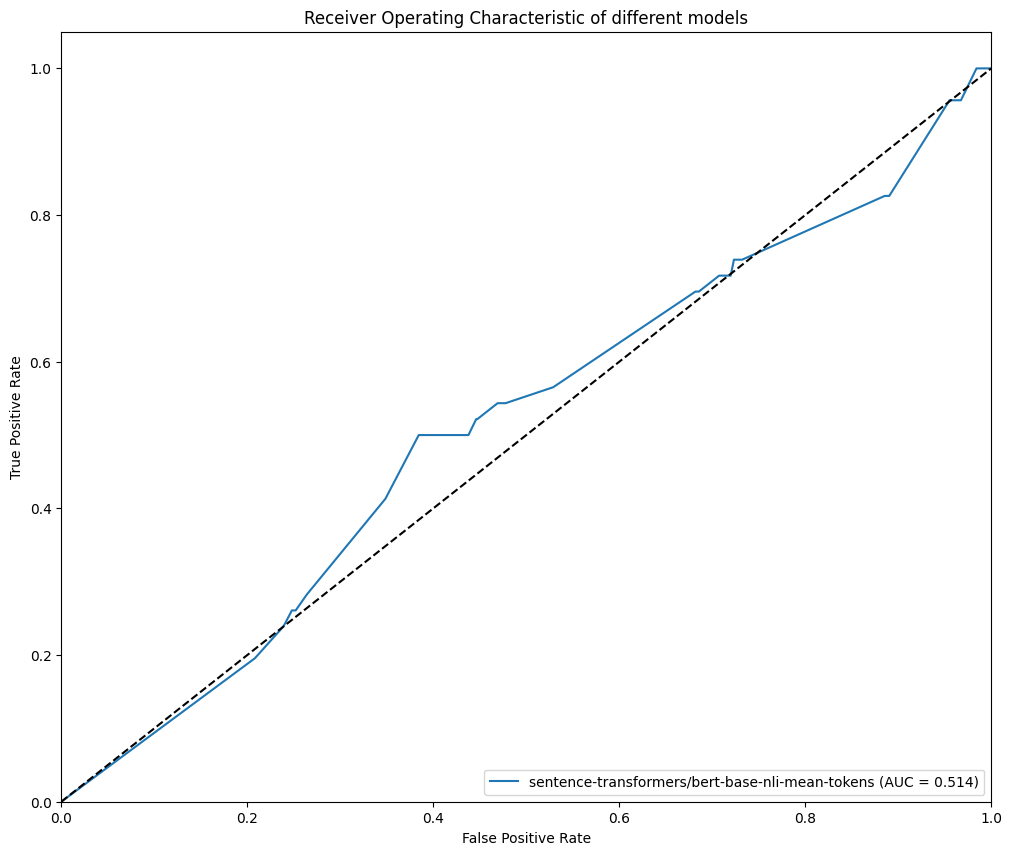

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_structure_evaluation_validation_100.png')
plt.show()

In [17]:
model_auc

{'sentence-transformers/bert-base-nli-mean-tokens': 0.5137842222852684}